# [Analyzing 1000+ Greek Wines With Python](https://tselai.com/greek-wines-analysis.html)

One of my most enjoyable guilty pleasures has always been [web scraping](https://en.wikipedia.org/wiki/Web_scraping).
Especially during the past year I have scraped countless websites, both for fun and profit.
From niche and mainstream e-shops to news outlets and literary blogs, it is amazing how much interesting and clean data one can get by using simple tools like `BeautifulSoup`- I won't even mention what a joy Chrome's Headless mode has been.

In this post I'll play with the data I scraped from a [Greek wine e-shop](http://www.houseofwine.gr/). In lieu of apology for sending a few more requests to their server I urge everyone browse through their catalog and maybe even buy a few bottles.

The scraper itself is fairly simple and can be found on my [GitHub page](https://github.com/Florents-Tselai/greek-wines-analysis). Here I'll focus on doing some quick exploratory analysis on the data I got (1125 unique labels) by using standard python packages.

The scraper itself exposes a fairly simple API. You request data for a given wine page and it returns a nice `dict` with the data, like this:

In [1]:
from houseofwine_gr import get

In [2]:
get('http://www.houseofwine.gr/how/megas-oinos-skoura.html')

{'ageable': True,
 'alcohol_%': 13.5,
 'avg_rating_%': 82,
 'color': 'Ερυθρός',
 'description': 'Στιβαρό ερυθρό κρασί παλαίωσης. Βασίζεται σε χαρμάνι που παντρεύει το πικάντικο σκέρτσο του Αγιωργίτικου με την αυστηρή δύναμη του Cabernet Sauvignon, στη ζεστή και βανιλάτη αγκαλιά του δρύινου βαρελιού που τα φιλοξένησε κατά την 20μηνη παλαίωσή του. Ποιοτική ετικέτα για μεγάλα φαγοπότια ή εκλεκτά κελάρια.',
 'drink_now': False,
 'keep_2_3_years': False,
 'n_votes': 21,
 'name': 'Μέγας Οίνος Σκούρα 2014',
 'price': 20.9,
 'tags': ['Ήπιος', 'Αγιωργίτικο', 'Ξηρός', 'Cabernet Sauvignon'],
 'url': 'http://www.houseofwine.gr/how/megas-oinos-skoura.html',
 'year': 2014}

We start by defining some `matplotlib` aesthetics.

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt

import matplotlib as mpl
import seaborn as sns

plt.style.use('fivethirtyeight')

mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['font.size'] = 14
mpl.rcParams['font.family'] = 'Serif'
mpl.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor']='white'
plt.rcParams['axes.grid'] =False
plt.rcParams['figure.facecolor']='white'

We load a dump of the data produced by the `houseofwine_gr.dump` module. You can find the dataset in `.json, .csv and .xlsx` in the GitHub page as well.

In [4]:
import pandas as pd

df = pd.read_json('./data/houseofwine.gr-wines.json', encoding='utf-8')

Here's a view of the data we have.

In [5]:
df.head()

,ageable,alcohol_%,avg_rating_%,color,description,drink_now,keep_2_3_years,n_votes,name,price,tags,url,year
0,False,8.5,,Λευκός,Κάποια από τα Riesling του Rheingau της Γερμαν...,False,True,,Riesling Spatlese 2013,33.7,"[Riesling, Ήπιος, Ημίγλυκος]",http://www.houseofwine.gr/how/riesling-spatles...,2013.0
1,False,13.5,,Λευκός,Τυπικό Νέο-Ζηλανδέζικο Sauvignon Blanc από ένα...,True,False,,Spy Valley - Sauvignon Blanc 2016,18.3,"[Ήπιος, Sauvignon Blanc, Ξηρός]",http://www.houseofwine.gr/how/spy-valley-sauvi...,2016.0
2,True,13.0,,Ερυθρός,Η κορωνίδα του Κτήματος Χρυσοχόου και ταυτόχρο...,False,False,,Cava Χρυσοχόου 2008,25.0,"[Ήπιος, Ξηρός, Ξινόμαυρο, Merlot]",http://www.houseofwine.gr/how/cava-hrysohoou.html,2008.0
3,False,12.5,90,Λευκός,Ένα από τα δημοφιλέστερα λευκά κρασιά στην Ελλ...,True,False,27,Κτήμα Γεροβασιλείου - Λευκός 2016,12.1,"[Ήπιος, Ξηρός, Ασύρτικο, Μαλαγουζιά]",http://www.houseofwine.gr/how/ktima-gerovasile...,2016.0
4,False,13.5,,Ερυθρός,Εισαγωγή στα κρασιά από τη γηγενή ποικιλία της...,False,True,,Landskroon - Pinotage 2013,13.1,"[Ήπιος, Ξηρός, Pinotage]",http://www.houseofwine.gr/how/landskroon-pinot...,2013.0


We replace empty strings with `np.nan` to make them easier to handle for `Pandas`

In [6]:
from numpy import nan
df = df.replace('', nan, regex=True)

We rename some column names containing special characters in order to use them as native `DataFrame` accessors.

In [7]:
df = df.rename(columns={'alcohol_%': 'alcohol', 'avg_rating_%': 'avg_rating'}, inplace=False)

We also assign appropriate types to the columns.

In [8]:
df['alcohol'] = df.alcohol.astype(float)
df['n_votes'] = df.n_votes.astype(int, errors='ignore')
df['price'] = df.price.astype(float)
df['year'] = df.year.astype(int, errors='ignore')

Let's translate the `color` column values from Greek to English.

In [9]:
df['color'] = df.color.replace({'Λευκός': 'White',
                                'Ερυθρός': 'Red', 
                                'Ροζέ': 'Rosé'
                               }
                              )

Here is a color histogram for our dataset.

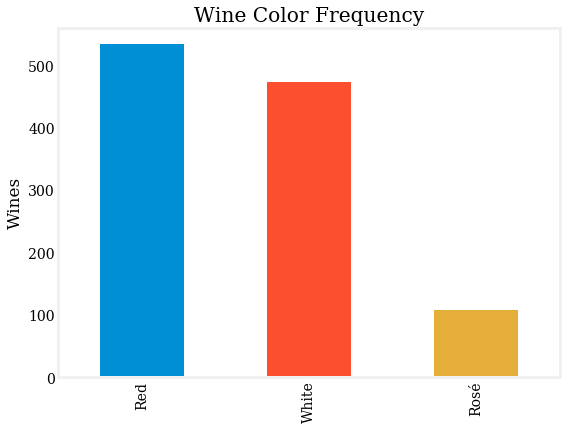

In [10]:
ax = df['color'].value_counts().plot('bar')
ax.set(ylabel='Wines', title='Wine Color Frequency');

Let's check out the distribution of some straightforward metrics for each wine.

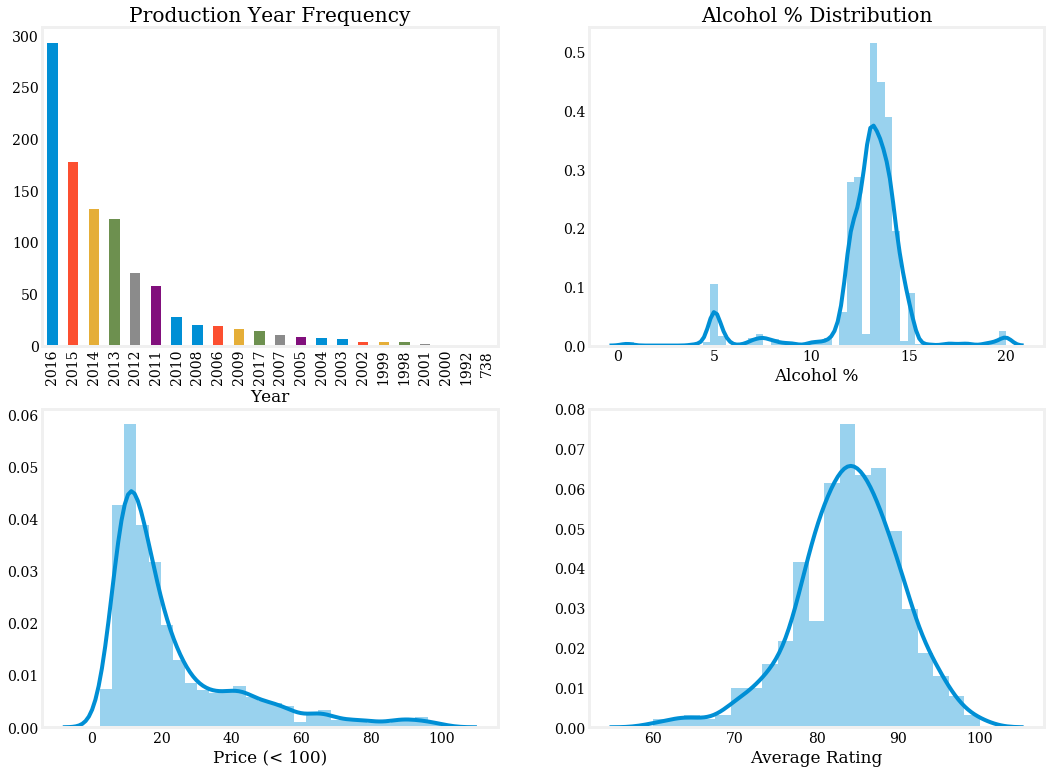

In [11]:
fig, ((ax1, ax2), 
      (ax3, ax4)
     ) = plt.subplots(ncols=2, nrows=2, figsize=(16,12))

df.year.dropna().astype(int).value_counts().plot('bar', ax=ax1)
ax1.set(title='Production Year Frequency', xlabel='Year');

sns.distplot(df[df.alcohol < 100].alcohol.dropna(), ax=ax2)
ax2.set(xlabel='Alcohol %', title='Alcohol % Distribution');

sns.distplot(df[df.price < 100].price.dropna(), ax=ax3)
ax3.set(xlabel='Price (< 100)')

sns.distplot(df.avg_rating.dropna(), ax=ax4)
ax4.set(xlabel='Average Rating');

An immediate observation is the almost-normal distribution one sees for the `Average Rating` column with a high mean of 85+.
[Kroutoner on Reddit](https://www.reddit.com/r/datascience/comments/7e0mw5/analyzing_1000_greek_wines_with_python/dq1x4ls/) explains why this happens (and also corrects a previous mistake of mine):

*The typical wine rating scale is on 50-100, not 0-100. So what looked like was a distribution with only half support is actually a nearly fully supported distribution with slight left skew. Further, there's a huge difference culturally between wines with ratings below and above 90, with wines receiving a rating above 90 generally being considered significantly better and also selling significantly better. This cultural fact completely changes the reasonable interpretation of the data. Most wines are rated as ok and only a small portion being rated as really good.*

To move things further, let's have a look at the `tags` column.

In [12]:
df.tags.head(10)

0                         [Riesling, Ήπιος, Ημίγλυκος]
1                      [Ήπιος, Sauvignon Blanc, Ξηρός]
2                    [Ήπιος, Ξηρός, Ξινόμαυρο, Merlot]
3                 [Ήπιος, Ξηρός, Ασύρτικο, Μαλαγουζιά]
4                             [Ήπιος, Ξηρός, Pinotage]
5                           [Ήπιος, Sangiovese, Ξηρός]
6                            [Ήπιος, Ξηρός, Ξινόμαυρο]
7    [Cabernet Sauvignon, Ήπιος, 13, Ξηρός, Merlot,...
8                                      [Ήπιος, Γλυκός]
9                               [Ήπιος, Αηδάνι, Ξηρός]
Name: tags, dtype: object

It looks like each list of tags can give us info about various wine attributes (varietal(s), sweetness etc.), so we would be better of if we made these attributes separate columns.

First we convert `tags` column elements from `list` to `set` ones, as this will make manipulations easier. That is, instead of getting messed up in an `if x in -else-try-except-IndexError` we're going to use `set` operations. Say what you want about the 79 character limit and readability; in interactive mode one-liners and immutable operations rock.

In [13]:
df['tags'] = df.tags.map(set)

We now do some simple operations to extract info about sweetness, mildness and wether or not is sparkling.
We also translate from Greek to English.

In [14]:
sweetness_values = {'Γλυκός', 'Ημίγλυκος', 'Ξηρός', 'Ημίξηρος'}
df['sweetness'] = df.tags.map(sweetness_values.intersection).map(lambda x: x.pop() if x else None)

translations = {'Γλυκός': 'Sweet', 'Ημίγλυκος': 'Semi-Sweet', 'Ξηρός': 'Dry', 'Ημίξηρος': 'Semi-Dry'}
df['sweetness'] = df['sweetness'].replace(translations)

In [15]:
df['sparkling'] = df.tags.map({'Αφρώδης', 'Ημιαφρώδης'}.intersection
                             ).map(lambda x: x.pop() if x else None
                                  ).replace({'Αφρώδης': 'Sparkling', 'Ημιαφρώδης': 'Semi-Sparkling'})
df['sparkling'] = df.sparkling.fillna('Not Sparkling')

In [16]:
df['is_mild'] = df.tags.map(lambda x: 'Ήπιος' in x)

Here are the histogram for each one of these 4 attributes.

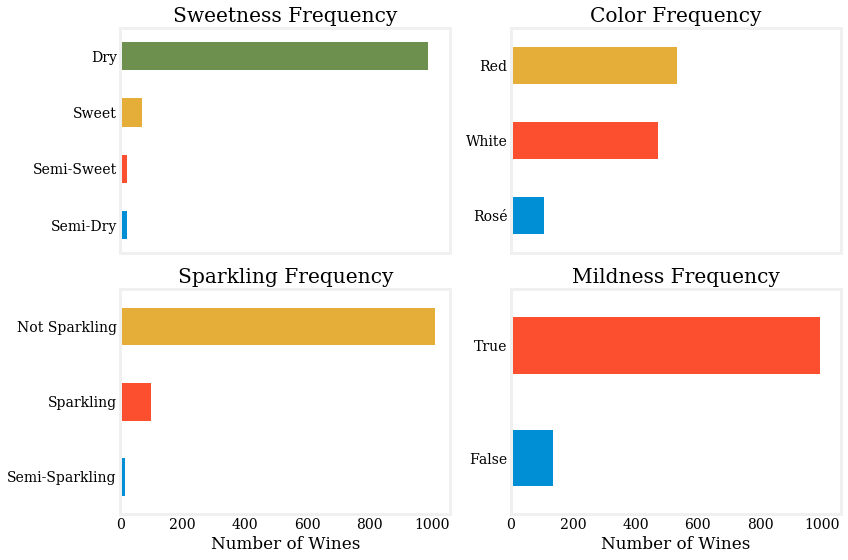

In [17]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharex=True, squeeze=False)

for attr, ax in zip(['sweetness', 'color', 'sparkling', 'is_mild'], (ax1, ax2, ax3, ax4)):
    df[attr].value_counts().sort_values(ascending=True).plot(kind='barh', ax=ax)
    attr_str = 'Mildness' if attr is 'is_mild' else attr.title()
    ax.set(xlabel='Number of Wines', title='{} Frequency'.format(attr_str));
    
fig.set_size_inches((12,8))
fig.tight_layout()

At this point we can (almost) safely assume that all remaining tags indicate varietal info for each wine and so we define a new column to store them.

In [18]:
non_varietal_tags = {'Αφρώδης', 'Ημιαφρώδης', 'Ξηρός', 'Ημίξηρος', 'Γλυκός', 'Ημίγλυκος', 'Ήπιος'}
df['varieties'] = df.tags.map(lambda t: t.difference(non_varietal_tags))

Due to a parsing bug there are some integers appearing as varieties in the column, so we filter these out.

In [19]:
def is_not_int(x):
    try:
        int(x)
        return False
    except ValueError:
        return True
    
df['varieties'] = df.varieties.map(lambda x: set(filter(is_not_int, x)))

We can also add a boolean variable of wether or not a wine is **varietal**. We define as varietal wine, one that has only one variety in its mix. The rest - with at least two varieties in their mix - are **blends**.

In [20]:
df['is_varietal'] = df.varieties.map(set.__len__) == 1

For varietal wines in particular we set a `single_variety` - this value will be `NaN` for the rest of the non-varietal wines.

In [21]:
df.loc[df.is_varietal, 'single_variety'] = df.loc[df.is_varietal, 'varieties'].map(lambda v: next(iter(v)))

In [22]:
df['is_blend'] = df.varieties.map(set.__len__) >= 2

In [23]:
df.loc[df.is_varietal, 'variety_type'] = 'Varietal'
df.loc[df.is_blend, 'variety_type'] = 'Blend'

Let's see how the Varietal / Blend distribution looks like.

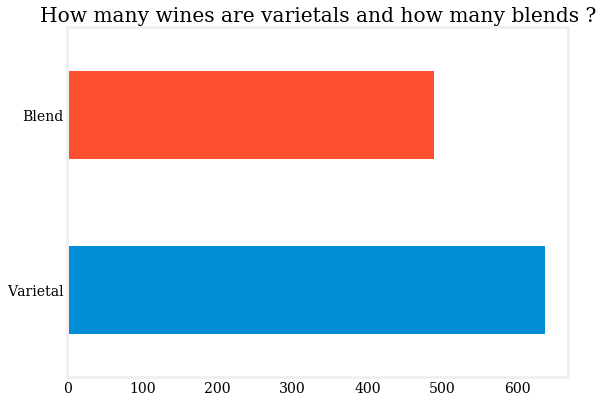

In [24]:
ax = df.is_varietal.replace({True: 'Varietal', 
                        False: 'Blend'}
                      ).value_counts().plot('barh')
ax.set(title='How many wines are varietals and how many blends ?');

Let's dig into the varieties stuff - should be interesting.

Here are some indicative plots.

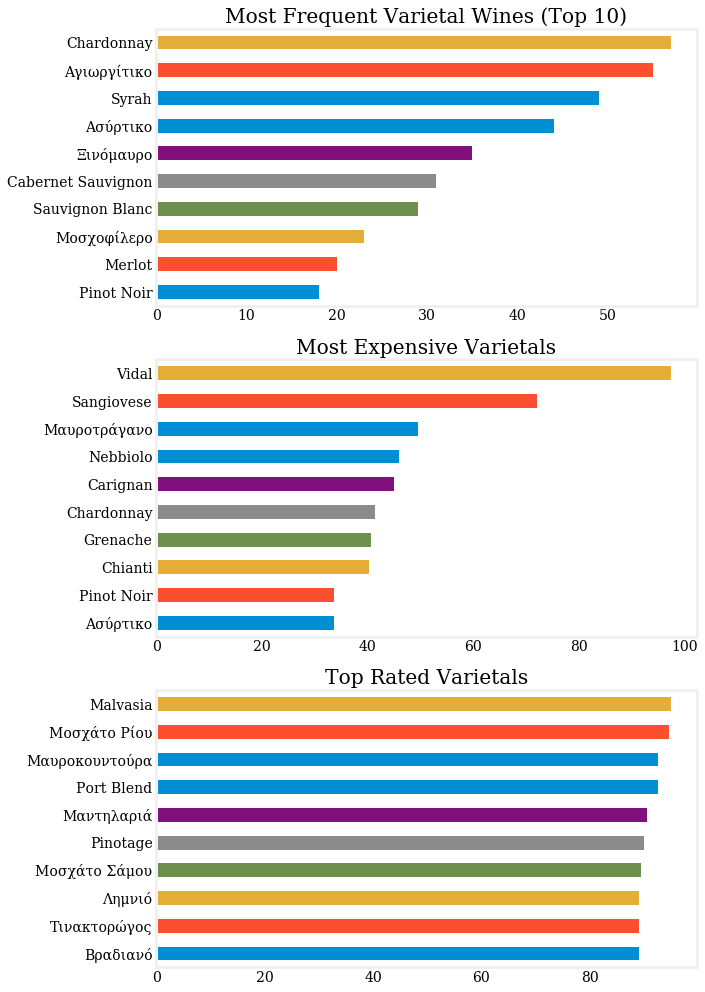

In [25]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(10,14))
fig.tight_layout

varieties_hist = df[df.is_varietal].varieties.map(lambda x: next(iter(x))).value_counts()
varieties_hist.head(10).sort_values(ascending=True).plot('barh', ax=ax1)
ax1.set(title='Most Frequent Varietal Wines (Top 10)');

varietals_mean_price = df[['single_variety', 'price']].groupby('single_variety').mean().dropna()['price']
varietals_mean_price.sort_values(ascending=False).head(10).sort_values(ascending=True).plot('barh', ax=ax2)
ax2.set(title='Most Expensive Varietals', xlabel='', ylabel='');

varietals_mean_rating = df[['single_variety', 'avg_rating']].groupby('single_variety').mean().dropna()['avg_rating']
varietals_mean_rating.sort_values(ascending=False).head(10).sort_values(ascending=True).plot('barh', ax=ax3);
ax3.set(title='Top Rated Varietals', ylabel='');

fig.tight_layout()

Looks likes `Chardonnay` is the most popular varietal while `Vidal` and `Sangiovese` are the most expensive ones. The top rated one is `Malvasia` but all varieties are pretty close.

Shifting our attention to blends, we do some `Numpy` and `Scikit-Learn` magic to produce a coocurrence matrix of the varieties appearing in blends.

In [26]:
def create_coocurrence_df(docs):
    # Source: https://stackoverflow.com/a/37822989
    count_model = CountVectorizer(lowercase=False, min_df=.1) # default unigram model
    X = count_model.fit_transform(docs)
    Xc = (X.T * X) # this is co-occurrence matrix in sparse csr format
    Xc.setdiag(0) # sometimes you want to fill same word cooccurence to 0
    ret = pd.DataFrame(Xc.todense())#, index=count_model.get_feature_names(), columnscou=count_model.get_feature_names())
    ret.index = ret.columns = list(map(lambda f: f.replace('_', ' '), count_model.get_feature_names()))
    return ret

In [27]:
from sklearn.feature_extraction.text import CountVectorizer
docs = df.loc[df.is_blend, 'varieties'].map(lambda x: {s.replace(' ', '_') for s in x}).map(lambda x: ' '.join(x))

coocurrence = create_coocurrence_df(docs)

The code above simple gets us from this:

In [28]:
df.loc[df.is_blend, 'varieties'].head(10)

2                       {Ξινόμαυρο, Merlot}
3                    {Ασύρτικο, Μαλαγουζιά}
7     {Λιάτικο, Merlot, Cabernet Sauvignon}
11                        {Viognier, Syrah}
13              {Sauvignon Blanc, Semillon}
16             {Merlot, Cabernet Sauvignon}
22              {Syrah, Cabernet Sauvignon}
23                      {Tannat, Ξινόμαυρο}
29                     {Sangiovese, Merlot}
35                        {Ασύρτικο, Αθήρι}
Name: varieties, dtype: object

To this:

In [29]:
coocurrence

,Cabernet Franc,Cabernet Sauvignon,Chardonnay,Merlot,Pinot Noir,Syrah,Αγιωργίτικο,Ασύρτικο
Cabernet Franc,0,42,0,52,0,2,1,0
Cabernet Sauvignon,42,0,0,85,1,24,21,0
Chardonnay,0,0,0,0,46,0,0,8
Merlot,52,85,0,0,1,29,7,0
Pinot Noir,0,1,46,1,0,1,0,0
Syrah,2,24,0,29,1,0,11,0
Αγιωργίτικο,1,21,0,7,0,11,0,0
Ασύρτικο,0,0,8,0,0,0,0,0


These are the varieties that appear most frequently in blends.

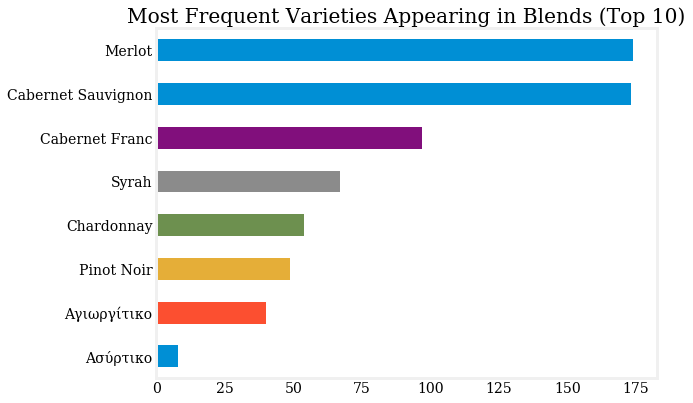

In [30]:
ax = coocurrence.sum().sort_values(ascending=False).head(10).sort_values(ascending=True).plot(kind='barh')
ax.set(title='Most Frequent Varieties Appearing in Blends (Top 10)');

And here is a heatmap showing which varieties are usually blended together.

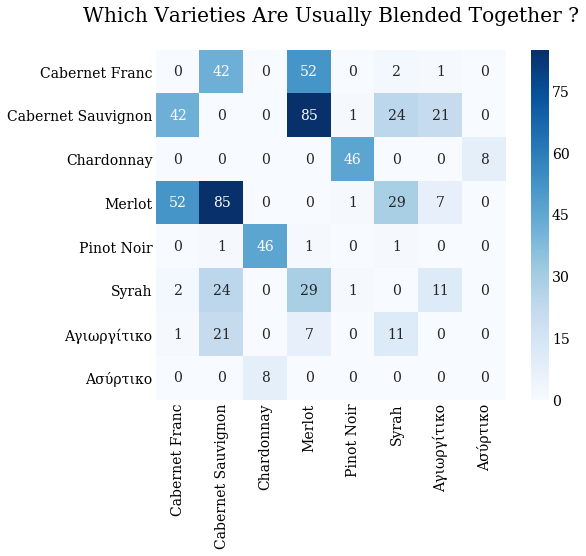

In [31]:
ax = sns.heatmap(coocurrence, square=True, annot=True, fmt="d", cmap='Blues')
ax.set(title='Which varieties are usually blended together ?\n'.title());
plt.gcf().set_size_inches((8,6))

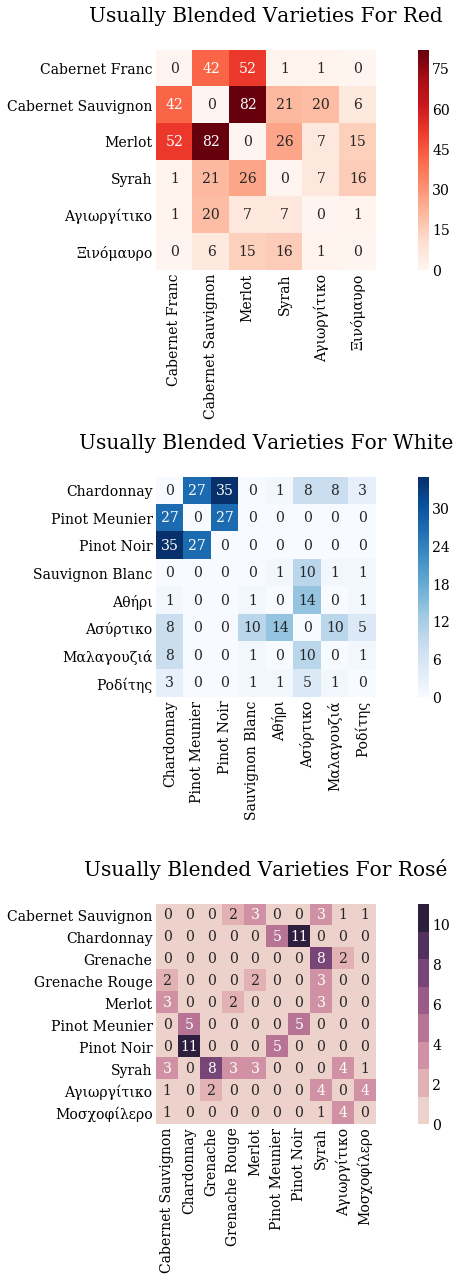

In [32]:
fig, axes = plt.subplots(nrows=3, figsize=(12, 18))
for c, ax in zip(['Red', 'White', 'Rosé'], axes):
    docs = df.loc[df.is_blend & (df.color==c), 'varieties'].map(lambda x: {s.replace(' ', '_') for s in x}).map(lambda x: ' '.join(x))
    cooc = create_coocurrence_df(docs)
    cmaps = {'Red': 'Reds', 'White': 'Blues', 'Rosé': sns.cubehelix_palette(8)}
    sns.heatmap(cooc, square=True, annot=True, fmt="d", cmap=cmaps.get(c), ax=ax)
    ax.set(title='Usually blended varieties for {}\n'.format(c).title());
plt.tight_layout()

That's all folks. A potential next step would be a classifier based on the textual `description` column I didn't touch here. Feel free to comment with ideas or play with the data yourself.